## Mangrove Project: Predict Probability of Accretion Given RSLR

We use two datasets combined, one based on the mangroves and the other based on the numerical GIA model

#### Load necessary Modules, Packages, and Data

In [1]:
# load packages and modules
date = '_2020'
import numpy as np
import sys
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors as c
from matplotlib import cm
#import netCDF4
import pandas as pd
import os
#import gzip
#import pickle
#import time
#import random
from sklearn.neighbors.kde import KernelDensity
from scipy.interpolate import interp1d
from scipy import interpolate as interpolate
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
main_dir = os.getcwd()

os.chdir(main_dir + '/PFILES/')
#os.chdir('/Users/ericaashe/Dropbox/Code/Python/MangroveProject/PFILES/')
from plot_calc_load_funcs import *

# load data
# RSL (GIA) data
os.chdir(main_dir + '/IFILES/')
#os.chdir('/Users/ericaashe/Dropbox/Code/Python/MangroveProject/IFILES/')
pgia = load_pickle("pgia_all.pkl")
giamods = load_pickle("modrange.pkl")
nages = load_pickle("nages.pkl")
#points_latlon = load_pickle("points_latlon.pkl")

# Mangrove data
#df = pd.read_csv('RSLRPublication.csv')
df = pd.read_csv('MangroveCorrData.csv')
#df = pd.read_csv('MangroveData.csv')
os.chdir(main_dir)

lat = df['Latitude'].values
lon = df['Longitude'].values
tide_class = df['Type'].values
geo_set = df['Geomorphic setting'].values

el_age = df['end4'].values
age_beg1 = df['beg1'].values
age_beg4 = df['beg4'].values
bl_age = age_beg4+300
bf_age = age_beg1+300

accret_rate = df['Rate (mm yr-1)'].values.reshape([122,1])
prox = -(df['intermediate-Field'].values - 1).reshape([122,1])
tide_class = df['Type'].values.reshape([122,1])
geo_set = df['Geomorphic setting'].values.reshape([122,1])

# define ages with RSL data, color map, dates to predict and Earth parameters of models
ages = np.arange(12.5, -.5, -.5)
cmap1 = cm.get_cmap("viridis")
testt = np.arange(0, 12.6, .1)
gia_param_names = ['lt', 'umv', 'lmv']
# subtract RSL prediction at time 0 to adjust to present for each model
pgia1 = np.empty(pgia.shape)
for ii in range(len(ages)):
    pgia1[:, :, ii] = pgia[:, :, ii] - pgia[:, :, -1]

/Users/ericaashe/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Plot average RSLR over time at intermediate-field sites and at far-field sites

(1230000, 1)


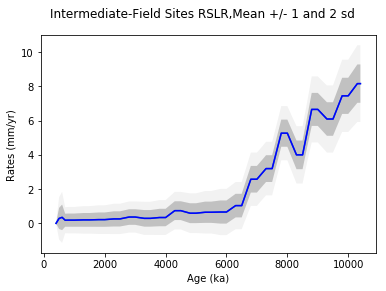

In [2]:
# RSLR over time for intermediate field sites
sel1 = np.squeeze(np.where((df['intermediate-Field']==1) & (df['Dup']==0)))

pgia_int = pgia1[:, np.squeeze(sel1), :]
age_ave = 300
age_per = 100
startage = 10500

rates1, rate_ages = calculate_lin_gia_rates(pgia_int, ages, age_ave, age_per)
ages_r = np.squeeze(np.where((rate_ages < startage) & (rate_ages > 0)))
rb_ave = np.empty(ages_r.shape)
rb_sd = np.empty(ages_r.shape)
xx = np.empty(ages_r.shape)
rb_comb = np.empty((len(rates1[0, :, 0]), len(rate_ages)))
rb_combnan = np.empty(rates1[:, :, :].shape)
rb_combnan[:, :, :] = np.nan

ct = 0
for ii in range(np.asarray(np.where(rate_ages < startage))[0][0], np.asarray(np.where(rate_ages < startage))[0][-1]):
    xx = np.asarray(np.where(bf_age[sel1] > 0))
    rb_ave[ct] = np.nanmean(rates1[:, xx, ii])
    rb_comb = np.append(rb_comb, rates1[:, xx, ii])
    rb_combnan[:, xx, ii] = rates1[:, xx, ii]
    rb_sd[ct] = np.nanstd(rates1[:, xx, ii])
    ct = ct + 1
bad_ind = np.isnan(np.asarray(rb_combnan))
good_ind0 = ~bad_ind
r_good1 = rb_combnan[good_ind0]
good_ind1 = r_good1 < 20
r_good = r_good1[good_ind1]
rbgood = r_good.reshape(-1, 1)
print(rbgood.shape)

rb_sd[np.where(abs(rb_sd)>2)] = 2
plt.plot(rate_ages[ages_r],rb_ave)
plt.plot(rate_ages[ages_r], rb_ave, 'b')
plt.fill_between(rate_ages[ages_r], rb_ave - 2*rb_sd, rb_ave + 2*rb_sd, facecolor = 'black', alpha=0.05)
plt.fill_between(rate_ages[ages_r], rb_ave - rb_sd, rb_ave + rb_sd, facecolor = 'black', alpha=0.2)
plt.suptitle('Intermediate-Field Sites RSLR,Mean +/- 1 and 2 sd')
plt.ylabel('Rates (mm/yr)')
plt.xlabel('Age (ka)')
plt.savefig('RSLR at Intermediate-Field Sites Through Time ' + str(startage) +'.pdf')

(1620000, 1)


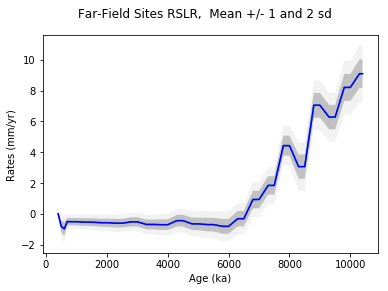

In [3]:
# RSLR over time for far-field sites
sel2 = np.squeeze(np.where((df['intermediate-Field']==0) & (df['Dup']==0)))

pgia_far = pgia1[:, np.squeeze(sel2), :]
age_ave = 300
age_per = 100
startage = 10500

rates2, rate_ages = calculate_lin_gia_rates(pgia_far, ages, age_ave, age_per)
ages_r = np.squeeze(np.where((rate_ages < startage) & (rate_ages > 0)))
rb_ave = np.empty(ages_r.shape)
rb_sd = np.empty(ages_r.shape)
xx = np.empty(ages_r.shape)
rb_comb = np.empty((len(rates2[0, :, 0]), len(rate_ages)))
rb_combnan = np.empty(rates2[:, :, :].shape)
rb_combnan[:, :, :] = np.nan

ct = 0
for ii in range(np.asarray(np.where(rate_ages < startage))[0][0], np.asarray(np.where(rate_ages < startage))[0][-1]):
    xx = np.asarray(np.where(bf_age[sel2] > 0))
    rb_ave[ct] = np.nanmean(rates2[:, xx, ii])
    rb_comb = np.append(rb_comb, rates2[:, xx, ii])
    rb_combnan[:, xx, ii] = rates2[:, xx, ii]
    rb_sd[ct] = np.nanstd(rates2[:, xx, ii])
    ct = ct + 1
bad_ind = np.isnan(np.asarray(rb_combnan))
good_ind0 = ~bad_ind
r_good1 = rb_combnan[good_ind0]
good_ind1 = r_good1 < 20
r_good = r_good1[good_ind1]
rbgood = r_good.reshape(-1, 1)
print(rbgood.shape)

rb_sd[np.where(abs(rb_sd)>2)] = 2
plt.plot(rate_ages[ages_r],rb_ave)
plt.plot(rate_ages[ages_r], rb_ave, 'b')
plt.fill_between(rate_ages[ages_r], rb_ave - 2*rb_sd, rb_ave + 2*rb_sd, facecolor = 'black', alpha=0.05)
plt.fill_between(rate_ages[ages_r], rb_ave - rb_sd, rb_ave + rb_sd, facecolor = 'black', alpha=0.2)
plt.suptitle('Far-Field Sites RSLR,  Mean +/- 1 and 2 sd')
plt.ylabel('Rates (mm/yr)')
plt.xlabel('Age (ka)')
plt.savefig('RSLR at Far-Field Sites Through Time ' + str(startage) +'.pdf')

/Users/ericaashe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/Users/ericaashe/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(44700, 1)
KernelDensity(algorithm='auto', atol=0, bandwidth=0.1, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)


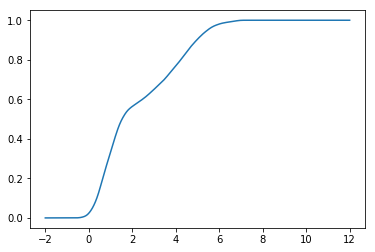

In [4]:
## During initiation (from beginning to end of initiation) for intermediate-field sites
sel1 = np.squeeze(np.where((df['intermediate-Field']==1) & (df['Dup']==0)))

pgia_int = pgia1[:, np.squeeze(sel1), :]
age_ave = 200
age_per = 100
startage = 10000

rates1, rate_ages = calculate_lin_gia_rates(pgia_int, ages, age_ave, age_per)

ages_r = np.squeeze(np.where((rate_ages < startage) & (rate_ages > 0)))
rb_ave = np.empty(ages_r.shape)
rb_sd = np.empty(ages_r.shape)
xx = np.empty(ages_r.shape)
rb_comb = np.empty((len(rates1[0, :, 0]), len(rate_ages)))
rb_combnan = np.empty(rates1[:, :, :].shape)
rb_combnan[:, :, :] = np.nan

ct = 0
for ii in range(np.asarray(np.where(rate_ages < startage))[0][0], np.asarray(np.where(rate_ages < startage))[0][-1]):
    xx = np.asarray(np.where((bf_age[sel1] > rate_ages[ii]) & (bl_age[sel1] < rate_ages[ii])))
    rb_ave[ct] = np.nanmean(rates1[:, xx, ii])
    rb_comb = np.append(rb_comb, rates1[:, xx, ii])
    rb_combnan[:, xx, ii] = rates1[:, xx, ii]
    rb_sd[ct] = np.nanstd(rates1[:, xx, ii])
    ct = ct + 1
bad_ind = np.isnan(np.asarray(rb_combnan))
good_ind0 = ~bad_ind
r_good1 = rb_combnan[good_ind0]
good_ind1 = r_good1 < 20
r_good = r_good1[good_ind1]
rbgood = r_good.reshape(-1, 1)
print(rbgood.shape)
## Fit a density to this histogram
from sklearn.neighbors.kde import KernelDensity
kde_beg = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(rbgood)
X_plot = np.linspace(-2, 12, 3000)[:, np.newaxis]
log_dens1 = kde_beg.score_samples(X_plot)
print(kde_beg)
wid = X_plot[1] - X_plot[0]
cum_dens1 = np.empty(log_dens1.shape)
for ii in range(1, len(cum_dens1)):
    cum_dens1[ii] = cum_dens1[ii-1] + np.exp(log_dens1)[ii] * wid 
plt.plot(X_plot, cum_dens1)
## quantiles
plt.savefig('CDF - Intermediate Field Rates at Initiation through ' + str(startage) + '_' + date + '.pdf')


0.9999999999993782
(44700, 1)
1.0


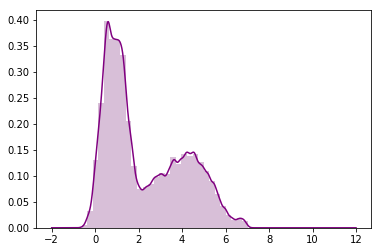

In [5]:
q01 = X_plot[np.where(cum_dens1<.01)][-1]
q05 = X_plot[np.where(cum_dens1<.05)][-1]
q10 = X_plot[np.where(cum_dens1<.10)][-1]
q50 = X_plot[np.where(cum_dens1<.50)][-1]
q90 = X_plot[np.where(cum_dens1<.90)][-1]
q95 = X_plot[np.where(cum_dens1<.95)][-1]
q99 = X_plot[np.where(cum_dens1<.99)][-1]
q995 = X_plot[np.where(cum_dens1<.995)][-1]
q9999 = X_plot[np.where(cum_dens1<.99999)][-1]
quants = {}
wid = X_plot[1] - X_plot[0]
print((wid * np.exp(log_dens1)).sum())
## Check that histogram discretely "integrates" to 1
hist = plt.hist(rbgood, bins = 30, density=True, color = 'thistle')
print(rbgood.shape)
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
print((density * widths).sum())
plt.plot(X_plot[:,0], np.exp(log_dens1), 'purple')
plt.savefig('RSL Rates Intermediate-Field Sites Initiation dates through ' + str(startage) + '_' + date + '.pdf')

/Users/ericaashe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/Users/ericaashe/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(67500, 1)
KernelDensity(algorithm='auto', atol=0, bandwidth=0.1, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)


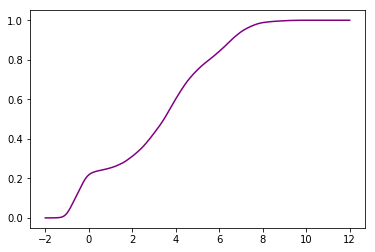

In [6]:
## During initiation (from beginning to end of initiation) for far-field sites
sel2 = np.squeeze(np.where((df['intermediate-Field']==0) & (df['Dup']==0)))

pgia_far = pgia1[:, np.squeeze(sel2), :]
age_ave = 200
age_per = 100

rates0, rate_ages = calculate_lin_gia_rates(pgia_far, ages, age_ave, age_per)
pareind = int(np.squeeze(np.where(df['Location']=='Pare Pare Indonesia')))
rates2 = rates0
rates2[:, 18, :] = rates0[:, pareind, :] - 1.38

startage = 10000
ages_r = np.squeeze(np.where((rate_ages < startage) & (rate_ages > 0)))

rb_ave = np.empty(ages_r.shape)
rb_sd = np.empty(ages_r.shape)
xx = np.empty(ages_r.shape)
rb_comb = np.empty((len(rates2[0, :, 0]), len(rate_ages)))
rb_combnan = np.empty(rates2[:, :, :].shape)
rb_combnan[:, :, :] = np.nan

ct = 0
for ii in range(np.asarray(np.where(rate_ages < startage))[0][0], np.asarray(np.where(rate_ages < startage))[0][-1]):
    xx = np.asarray(np.where((bf_age[sel2] > rate_ages[ii]) & (bl_age[sel2] < rate_ages[ii])))
    rb_ave[ct] = np.nanmean(rates2[:, xx, ii])
    rb_comb = np.append(rb_comb, rates2[:, xx, ii])
    rb_combnan[:, xx, ii] = rates2[:, xx, ii]
    rb_sd[ct] = np.nanstd(rates2[:, xx, ii])
    ct = ct + 1
bad_ind = np.isnan(np.asarray(rb_combnan))
good_ind0 = ~bad_ind
r_good1 = rb_combnan[good_ind0]
good_ind1 = r_good1 < 20
r_good = r_good1[good_ind1]
rbgood = r_good.reshape(-1, 1)
print(rbgood.shape)
## Fit a density to this histogram
from sklearn.neighbors.kde import KernelDensity
kde_beg = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(rbgood)
#X_plot = np.linspace(-2, 15, 5000)[:, np.newaxis]
log_dens2 = kde_beg.score_samples(X_plot)
print(kde_beg)
wid = X_plot[1] - X_plot[0]
cum_dens2 = np.empty(log_dens2.shape)
for ii in range(1, len(cum_dens2)):
    cum_dens2[ii] = cum_dens2[ii-1] + np.exp(log_dens2)[ii] * wid 
plt.plot(X_plot, cum_dens2,color='purple')
## quantiles
plt.savefig('CDF Far-Field Rates Initiation through' + str(startage) + '_' + date + '.pdf')


0.9999998696204934
(67500, 1)
0.9999999999999999


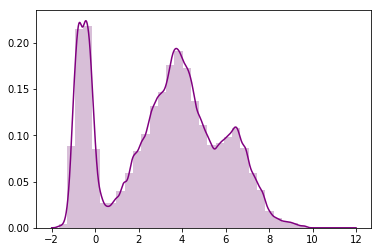

In [7]:
q01 = X_plot[np.where(cum_dens2<.01)][-1]
q05 = X_plot[np.where(cum_dens2<.05)][-1]
q10 = X_plot[np.where(cum_dens2<.10)][-1]
q50 = X_plot[np.where(cum_dens2<.50)][-1]
q90 = X_plot[np.where(cum_dens2<.90)][-1]
q95 = X_plot[np.where(cum_dens2<.95)][-1]
q99 = X_plot[np.where(cum_dens2<.99)][-1]
q995 = X_plot[np.where(cum_dens2<.995)][-1]
q9999 = X_plot[np.where(cum_dens2<.99999)][-1]
quants[2] = [q01, q05, q10, q50, q90, q95, q99, q995, q9999]
wid = X_plot[1] - X_plot[0]
print((wid * np.exp(log_dens2)).sum())
## Check that histogram discretely "integrates" to 1
hist = plt.hist(rbgood, bins = 30, density=True, color= 'thistle')
print(rbgood.shape)
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
print((density * widths).sum())
plt.plot(X_plot[:,0], np.exp(log_dens2), 'purple')
plt.savefig('RSL Rates Far Field Sites Initiation through ' + str(startage) + '_' + date + '.pdf')

/Users/ericaashe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/Users/ericaashe/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(112200, 1)
KernelDensity(algorithm='auto', atol=0, bandwidth=0.1, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)


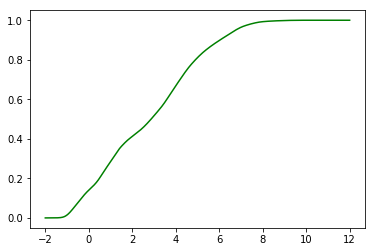

In [8]:
## During initiation (from beginning to end of initiation) for all sites
sel3 = np.squeeze(np.where((df['intermediate-Field'] < 2) & (df['Dup']==0)))

pgia_all = pgia1[:, np.squeeze(sel3), :]
age_ave = 200
age_per = 100

rates0, rate_ages = calculate_lin_gia_rates(pgia_all, ages, age_ave, age_per)
pareind = int(np.squeeze(np.where(df['Location']=='Pare Pare Indonesia')))
rates3 = rates0
rates3[:, 18, :] = rates0[:, pareind, :] - 1.38

startage = 10000
ages_r = np.squeeze(np.where((rate_ages < startage) & (rate_ages > 0)))
rb_ave = np.empty(ages_r.shape)
rb_sd = np.empty(ages_r.shape)
xx = np.empty(ages_r.shape)
rb_comb = np.empty((len(rates3[0, :, 0]), len(rate_ages)))
rb_combnan = np.empty(rates3[:, :, :].shape)
rb_combnan[:, :, :] = np.nan

ct = 0
for ii in range(np.asarray(np.where(rate_ages < startage))[0][0], np.asarray(np.where(rate_ages < startage))[0][-1]):
    xx = np.asarray(np.where((bf_age[sel3] > rate_ages[ii]) & (bl_age[sel3] < rate_ages[ii])))
    rb_ave[ct] = np.nanmean(rates3[:, xx, ii])
    rb_comb = np.append(rb_comb, rates3[:, xx, ii])
    rb_combnan[:, xx, ii] = rates3[:, xx, ii]
    rb_sd[ct] = np.nanstd(rates3[:, xx, ii])
    ct = ct + 1
bad_ind = np.isnan(np.asarray(rb_combnan))
good_ind0 = ~bad_ind
r_good1 = rb_combnan[good_ind0]
good_ind1 = r_good1 < 20
r_good = r_good1[good_ind1]
rbgood = r_good.reshape(-1, 1)
print(rbgood.shape)

## Fit a density to this histogram
from sklearn.neighbors.kde import KernelDensity
kde_beg = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(rbgood)
log_dens3 = kde_beg.score_samples(X_plot)
print(kde_beg)
wid = X_plot[1] - X_plot[0]
cum_dens3 = np.empty(log_dens3.shape)
for ii in range(1, len(cum_dens3)):
    cum_dens3[ii] = cum_dens3[ii-1] + np.exp(log_dens3)[ii] * wid 
plt.plot(X_plot, cum_dens3, color='green')
plt.savefig('CDF for All Sites at Initiation ' + str(startage) + '_' + date + '.pdf')

0.9999999215624207
(112200, 1)
1.0000000000000002


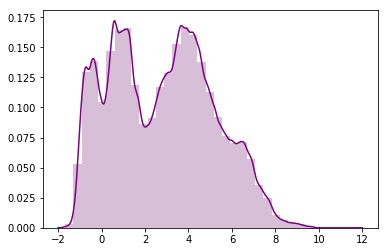

In [9]:
q01 = X_plot[np.where(cum_dens3<.01)][-1]
q05 = X_plot[np.where(cum_dens3<.05)][-1]
q10 = X_plot[np.where(cum_dens3<.10)][-1]
q50 = X_plot[np.where(cum_dens3<.50)][-1]
q90 = X_plot[np.where(cum_dens3<.90)][-1]
q95 = X_plot[np.where(cum_dens3<.95)][-1]
q99 = X_plot[np.where(cum_dens3<.99)][-1]
q995 = X_plot[np.where(cum_dens3<.995)][-1]
q9999 = X_plot[np.where(cum_dens3<.99999)][-1]
quants[3] = [q01, q05, q10, q50, q90, q95, q99, q995, q9999]
wid = X_plot[1] - X_plot[0]
print((wid * np.exp(log_dens3)).sum())

## Check that histogram discretely "integrates" to 1
hist = plt.hist(rbgood, bins = 30, density=True, color = 'thistle')
print(rbgood.shape)
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
print((density * widths).sum())
plt.plot(X_plot[:,0], np.exp(log_dens3), 'purple')
plt.savefig('RSL Rates All Sites Initiation through ' + str(startage) + date + '.pdf')

### Only run to plot rates at sites again

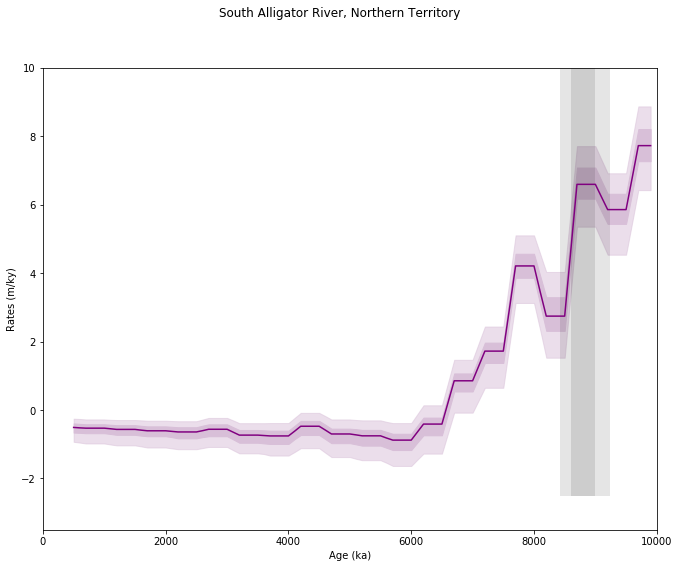

In [10]:
# All sites
seln = np.squeeze(np.where((df['intermediate-Field'] < 2) & (df['Dup']==0)))

X_plot = np.linspace(-2, 10, 3000)[:, np.newaxis]

pgia_n = pgia1[:, np.squeeze(seln), :]
age_ave = 200
age_per = 100

rates0, rate_ages = calculate_lin_gia_rates(pgia_n, ages, age_ave, age_per)
pareind = int(np.squeeze(np.where(df['Location']=='Pare Pare Indonesia')))
ratesn = rates0
ratesn[:, 18, :] = rates0[:, pareind, :] - 1.38

startage = 10000
ages_r = np.squeeze(np.where((rate_ages < startage) & (rate_ages > 0)))
rb_ave = np.empty(ages_r.shape)
rb_sd = np.empty(ages_r.shape)
xx = np.empty(ages_r.shape)
rb_comb = np.empty((len(ratesn[0, :, 0]), len(rate_ages)))
#rnan = np.isnan(rates)
rb_combnan = np.empty(ratesn[:, :, :].shape)
rb_combnan[:, :, :] = np.nan

bands = 1
ratesp = ratesn[:,:,np.squeeze(np.where((rate_ages < 10000) & (rate_ages> 400)))]
r_ages = rate_ages[np.squeeze(np.where((rate_ages < 10000) & (rate_ages > 400)))]
plot_site_rates(ratesp, r_ages, 'Rates (m/ky)', df, bands)

## Creates inverse density plots:

### Plots probabilities (inverse densities) for all proximities (intermediate-field, far-field, and all) with uncertainties.  Uncertainties are calculated through sampling

It took:  541.1477200984955  seconds
It took:  662.3088281154633  seconds
It took:  1241.691564798355  seconds


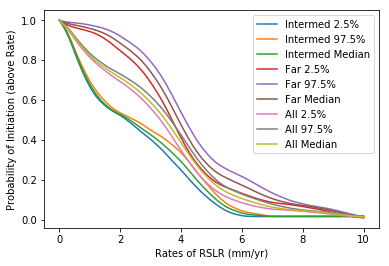

In [11]:
numpred = 101
# for faster runs, reduce the number of samples below  
# To ensure convergence, increase this number
numsamps = 10000
X_plot0 = np.linspace(0, 10, numpred)[:, np.newaxis]

inv_dens = np.empty((numsamps, len(X_plot0)))
inv_dens1 = inv_dens
inv_dens2 = inv_dens
inv_dens3 = inv_dens

#seed(6578)

for ll in arange(0, 3):
    if ll == 0:
        rates = rates1
        sel = sel1
        lbl = 'Intermediate Field'
    elif ll == 1:
        rates = rates2
        sel = sel2
        lbl = 'Far Field'
    elif ll == 2:
        rates = rates3
        sel = sel3
        lbl = 'All proximities'
        
    then = time.time()

    inv_dens = np.empty((numsamps, len(X_plot0)))
    #cprobinit0 = np.empty(len(X_plot0))
    wid = X_plot0[1] - X_plot0[0]

    # seed(101)  # seed for exact replicability
    for jj in range(numsamps):       
        cprobinit = np.empty(len(X_plot0))
        #print(cprobinit)
        branges = (bf_age[sel] - bl_age[sel])
        xs = np.empty((len(rates[0, :, 0]), 300))
        # get random ages (within initiation of accretion at each site)
        agesinit = bl_age[sel] + np.random.rand(len(rates[0,:,0]))*branges
        #GIAii = np.around(np.random.rand(len(rates[0, :, 0]))*300-0.5).astype(int)

        for ii in arange(len(agesinit)):
        #    for jj in arange(len(rates[0, :, 0])):
                rinterp = interp1d(rate_ages, rates[:, ii, :], kind='linear', axis = 1)
                xs[ii, :] = rinterp(agesinit[ii])
        kde_beg = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(xs.reshape(-1, 1))
        logd = kde_beg.score_samples(X_plot0)
        nconst = (wid * np.exp(logd)).sum()
        cdens = np.exp(logd)/nconst

        for kk in range(1, len(cprobinit)):
            cprobinit[0] = 0
            cprobinit[kk] = cprobinit[kk-1] + cdens[kk] * wid 
            #print(cdens[kk] * wid, cprobinit[kk])
            # print(np.exp(logdens)[kk] * wid )
        if np.amax(cprobinit) > 1.1:
            print('Something wrong:  cdf value greater than 1 for ' + str(jj))
            #print(sum(cdens*wid))
            #print(cprobinit)
            inv_dens[jj, :] = np.nan
        elif np.amin(cprobinit) <0:           
            print('Something wrong:  cdf value less than 0 for ' + str(jj))
            inv_dens[jj, :] = np.nan
        else:           
            inv_dens[jj, :] = 1-cprobinit

    if ll == 0:
        inv_dens1 = inv_dens
        cdens1 = cdens
    elif ll == 1:
        inv_dens2 = inv_dens
        cdens2 = cdens
    elif ll == 2:
        inv_dens3 = inv_dens
        cdens3 = cdens

    now = time.time() #Time after it finished
    print("It took: ", now-then, " seconds")

    # rinterp is an interpolation object that creates a list of rates at all GIA models 
    # for a site given a specific date
    
    plt.plot(X_plot0, np.quantile(inv_dens, .025, axis = 0))
    plt.plot(X_plot0, np.quantile(inv_dens, .975, axis = 0))
    plt.plot(X_plot0, np.median(inv_dens, axis = 0))

    plt.legend(('Intermed 2.5%','Intermed 97.5%','Intermed Median','Far 2.5%','Far 97.5%','Far Median','All 2.5%','All 97.5%','All Median'))
    plt.xlabel('Rates of RSLR (mm/yr)')
    plt.ylabel('Probability of Initiation (above Rate)')
    plt.savefig('Probability of Accretion ' + lbl  + '_' + date + '.pdf')


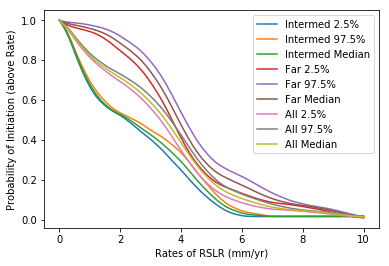

In [12]:
    plt.plot(X_plot0, np.quantile(inv_dens1, .025, axis = 0))
    plt.plot(X_plot0, np.quantile(inv_dens1, .975, axis = 0))
    plt.plot(X_plot0, np.median(inv_dens1, axis = 0))
    
    plt.plot(X_plot0, np.quantile(inv_dens2, .025, axis = 0))
    plt.plot(X_plot0, np.quantile(inv_dens2, .975, axis = 0))
    plt.plot(X_plot0, np.median(inv_dens2, axis = 0))
    
    plt.plot(X_plot0, np.quantile(inv_dens3, .025, axis = 0))
    plt.plot(X_plot0, np.quantile(inv_dens3, .975, axis = 0))
    plt.plot(X_plot0, np.median(inv_dens3, axis = 0))

    
    plt.legend(('Intermed 2.5%','Intermed 97.5%','Intermed Median','Far 2.5%','Far 97.5%','Far Median','All 2.5%','All 97.5%','All Median'))
    plt.xlabel('Rates of RSLR (mm/yr)')
    plt.ylabel('Probability of Initiation (above Rate)')
    plt.savefig('Probability of Accretion ' + lbl  + '_' + date + '.pdf')


### Saves rates and probabilities to an excel file

In [13]:
import xlwt 
from xlwt import Workbook 
  
# Workbook is created 
wb = Workbook() 
# add_sheet is used to create sheet. 
sheet1 = wb.add_sheet('Interm-Field') 
 
sheet1.write(0, 0, 'Rate  (mm/yr)')
sheet1.write(0, 2, '2.5th Percentile')
sheet1.write(0, 3, '5th Percentile')
sheet1.write(0, 4, '25th Percentile')
sheet1.write(0, 5, 'Median')
sheet1.write(0, 6, '75th Percentile')
sheet1.write(0, 7, '95th Percentile')
sheet1.write(0, 8, '97.5th Percentile')

for ii in range(0, len(cdens1)-1):
    inv_dens = inv_dens1
    sheet1.write(ii+1, 0, str(np.round(np.asscalar(np.squeeze(X_plot0[ii])),1)))
    sheet1.write(ii+1, 2, str(np.round(np.asscalar(np.quantile(inv_dens, .025, axis = 0)[ii+1])*100,1)) + '% ')
    sheet1.write(ii+1, 3, str(np.round(np.asscalar(np.quantile(inv_dens, .05, axis = 0)[ii+1])*100,1)) + '% ')
    sheet1.write(ii+1, 4, str(np.round(np.asscalar(np.quantile(inv_dens, .25, axis = 0)[ii+1])*100,1)) + '% ')
    sheet1.write(ii+1, 5, str(np.round(np.asscalar(np.quantile(inv_dens, 0.5, axis = 0)[ii+1])*100,1)) + '% ')
    sheet1.write(ii+1, 6, str(np.round(np.asscalar(np.quantile(inv_dens, .75, axis = 0)[ii+1])*100,1))  + '% ')
    sheet1.write(ii+1, 7, str(np.round(np.asscalar(np.quantile(inv_dens, .95, axis = 0)[ii+1])*100,1)) + '% ')
    sheet1.write(ii+1, 8, str(np.round(np.asscalar(np.quantile(inv_dens, .975, axis = 0)[ii+1])*100,1)) + '% ')
wb.save('posterior_probabilities.xls') 

sheet2 = wb.add_sheet('Far-Field') 
sheet2.write(0, 0, 'Rate  (mm/yr)')
sheet2.write(0, 2, '2.5th Percentile')
sheet2.write(0, 3, '5th Percentile')
sheet2.write(0, 4, '25th Percentile')
sheet2.write(0, 5, 'Median')
sheet2.write(0, 6, '75th Percentile')
sheet2.write(0, 7, '95th Percentile')
sheet2.write(0, 8, '97.5th Percentile')

for ii in range(0, len(cdens2)-1):
    inv_dens = inv_dens2
    sheet2.write(ii+1, 0, str(np.round(np.asscalar(np.squeeze(X_plot0[ii])),1)))
    sheet2.write(ii+1, 2, str(np.round(np.asscalar(np.quantile(inv_dens, .025, axis = 0)[ii+1])*100,1))  + '% ')
    sheet2.write(ii+1, 3, str(np.round(np.asscalar(np.quantile(inv_dens, .05, axis = 0)[ii+1])*100,1)) + '% ')
    sheet2.write(ii+1, 4, str(np.round(np.asscalar(np.quantile(inv_dens, .25, axis = 0)[ii+1])*100,1)) + '% ')
    sheet2.write(ii+1, 5, str(np.round(np.asscalar(np.quantile(inv_dens, 0.5, axis = 0)[ii+1])*100,1)) + '% ')
    sheet2.write(ii+1, 6, str(np.round(np.asscalar(np.quantile(inv_dens, .75, axis = 0)[ii+1])*100,1)) + '% ')
    sheet2.write(ii+1, 7, str(np.round(np.asscalar(np.quantile(inv_dens, .95, axis = 0)[ii+1])*100,1)) + '% ')
    sheet2.write(ii+1, 8, str(np.round(np.asscalar(np.quantile(inv_dens, .975, axis = 0)[ii+1])*100,1)) + '% ')

sheet3 = wb.add_sheet('All') 
sheet3.write(0, 0, 'Rate  (mm/yr)')
sheet3.write(0, 2, '2.5th Percentile')
sheet3.write(0, 3, '5th Percentile')
sheet3.write(0, 4, '25th Percentile')
sheet3.write(0, 5, 'Median')
sheet3.write(0, 6, '75th Percentile')
sheet3.write(0, 7, '95th Percentile')
sheet3.write(0, 8, '97.5th Percentile')

for ii in range(0, len(cdens3)-1):
    inv_dens = inv_dens3
    sheet3.write(ii+1, 0, str(np.round(np.asscalar(np.squeeze(X_plot0[ii])),1)))
    sheet3.write(ii+1, 2, str(np.round(np.asscalar(np.quantile(inv_dens, .025, axis = 0)[ii+1])*100,1)) + '% ')
    sheet3.write(ii+1, 3, str(np.round(np.asscalar(np.quantile(inv_dens, .05, axis = 0)[ii+1])*100,1)) + '% ')
    sheet3.write(ii+1, 4, str(np.round(np.asscalar(np.quantile(inv_dens, .25, axis = 0)[ii+1])*100,1)) + '% ')
    sheet3.write(ii+1, 5, str(np.round(np.asscalar(np.quantile(inv_dens, 0.5, axis = 0)[ii+1])*100,1)) + '% ')
    sheet3.write(ii+1, 6, str(np.round(np.asscalar(np.quantile(inv_dens, .75, axis = 0)[ii+1])*100,1)) + '% ')
    sheet3.write(ii+1, 7, str(np.round(np.asscalar(np.quantile(inv_dens, .95, axis = 0)[ii+1])*100,1)) + '% ')
    sheet3.write(ii+1, 8, str(np.round(np.asscalar(np.quantile(inv_dens, .975, axis = 0)[ii+1])*100,1)) + '% ')

wb.save('posterior_probabilities.xls') 

### Find the distribution of RLSR rates based on age for all initiation times

In [14]:
rates = rates3
sel = sel3
lbl = 'All proximities'
ages_r = np.squeeze(np.where((rate_ages < startage) & (rate_ages > 0)))
dates = rate_ages[ages_r] #106
rs = rates[:, :, ages_r] #300, 90, 106
indr = np.empty(rs[0,:,:].shape)
    #(ages_r.shape[0],rates[0, :, 0].shape[0]))
startage = 10000
ct = 0
for ii in range(np.asarray(np.where(rate_ages < startage))[0][0], np.asarray(np.where(rate_ages < startage))[0][-1]):
    indr[:, ct] = (bf_age[sel] > rate_ages[ii]) & (bl_age[sel] < rate_ages[ii])
    ct = ct + 1
## For each time, we assign the time to a bin, for each of the 300 models that have a rate within the bin
rate_bin1 = [0, 1, 2, 3, 4, 5, 6, 7, 8]
rate_bin2 = [1, 2, 3, 4, 5, 6, 7, 8, 20]

rs_by_rate = {}
lablist = []
for kk in range(len(rate_bin1)):
    rs_by_rate[kk] = np.empty(0, float)
    lablist.append('Rates: ' + str(rate_bin1[kk]) + ' - ' + str(rate_bin2[kk]))
lablist
for ii in range(len(indr[:, 0])):  # ii is 90 (each site)
    for jj in range(len(indr[0, :])): # jj is 106 (dates)
        if indr[ii, jj] == 1:
            for kk in range(len(rate_bin1)):
                for ll in range(len(rs[:, ii, jj])):                        
                    if (rs[ll, ii, jj] > rate_bin1[kk]) & (rs[ll, ii, jj] < rate_bin2[kk]):
                        rs_by_rate[kk] = np.append(rs_by_rate[kk], dates[jj])
rbr = pd.DataFrame(list(rs_by_rate.values()), index=rs_by_rate.keys())


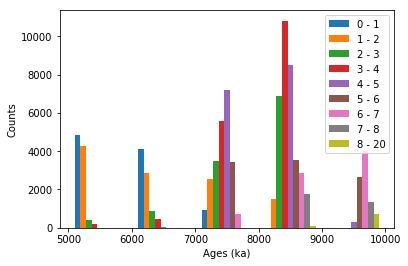

In [15]:
n, bins, patches = plt.hist(rbr, bins = [5000, 6000, 7000, 8000, 9000, 10000], histtype='bar')

plt.ylabel('Counts')
plt.xlabel('Ages (ka)')
lablist = []
for kk in range(len(rate_bin1)):
#    rs_by_rate[kk] = np.empty(0, float)
    lablist.append(str(rate_bin1[kk]) + ' - ' + str(rate_bin2[kk]))
lablist

leg = plt.legend(lablist)
plt.savefig('Rates at Initiation times grouped rates by age ' + str(startage)  + date + '.pdf')


In [16]:
# rates during all accretion times, from beginning to end
rates = rates3
sel = sel3
lbl = 'All proximities'
ages_r = np.squeeze(np.where((rate_ages < startage) & (rate_ages > 0)))
dates = rate_ages[ages_r] #106
rs = rates[:, :, ages_r] #300, 90, 106
indr = np.empty(rs[0,:,:].shape)
    #(ages_r.shape[0],rates[0, :, 0].shape[0]))
startage = 10000
ct = 0
for ii in range(np.asarray(np.where(rate_ages < startage))[0][0], np.asarray(np.where(rate_ages < startage))[0][-1]):
    indr[:, ct] = (bf_age[sel] > rate_ages[ii]) & (el_age[sel] < rate_ages[ii])
    ct = ct + 1
## For each time, we assign the time to a bin, for each of the 300 models that have a rate within the bin
rate_bin1 = [0, 1, 2, 3, 4, 5, 6, 7, 8]
rate_bin2 = [1, 2, 3, 4, 5, 6, 7, 8, 20]

rs_by_rate = {}
lablist = []
for kk in range(len(rate_bin1)):
    rs_by_rate[kk] = np.empty(0, float)
    lablist.append('Rates: ' + str(rate_bin1[kk]) + ' - ' + str(rate_bin2[kk]))
lablist
for ii in range(len(indr[:, 0])):  # ii is 90 (each site)
    for jj in range(len(indr[0, :])): # jj is 106 (dates)
        if indr[ii, jj] == 1:
            for kk in range(len(rate_bin1)):
                for ll in range(len(rs[:, ii, jj])):                        
                    if (rs[ll, ii, jj] > rate_bin1[kk]) & (rs[ll, ii, jj] < rate_bin2[kk]):
                        rs_by_rate[kk] = np.append(rs_by_rate[kk], dates[jj])
rbr = pd.DataFrame(list(rs_by_rate.values()), index=rs_by_rate.keys())


/Users/ericaashe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


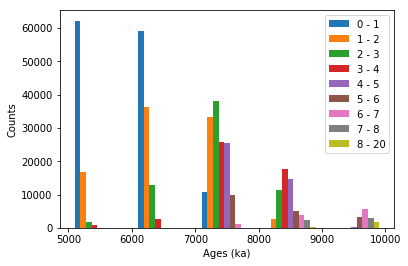

In [17]:
n, bins, patches = plt.hist(rbr, bins = [5000, 6000, 7000, 8000, 9000, 10000], histtype='bar')

plt.ylabel('Counts')
plt.xlabel('Ages (ka)')
lablist = []
for kk in range(len(rate_bin1)):
#    rs_by_rate[kk] = np.empty(0, float)
    lablist.append(str(rate_bin1[kk]) + ' - ' + str(rate_bin2[kk]))
lablist

leg = plt.legend(lablist)
plt.savefig('Rates During Accretion grouped rates by age ' + str(startage)  + date + '.pdf')
